# Dense Prediction: Monocular Depth Estimation and Semantic Segmentation

## Extract Data

In [ ]:
! unzip UnrealData256.zip

In [ ]:
! unzip VOC2012.zip

## Hyperparameters

In [ ]:
import os
import gc
import time
import datetime
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Change this to reflect 

epochs = 25
batch_size = 32
learning_rate = 0.007
workers = 2 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

## Data Loader

In [ ]:
if __name__ == '__main__':
    from loaders import prep_loaders
    train_loader, valid_loader = prep_loaders('UnrealData256', batch_size=batch_size, workers=workers)

Dataset size (num. batches) 793 17


## Sanity check 

Populating the interactive namespace from numpy and matplotlib
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 128, 128])


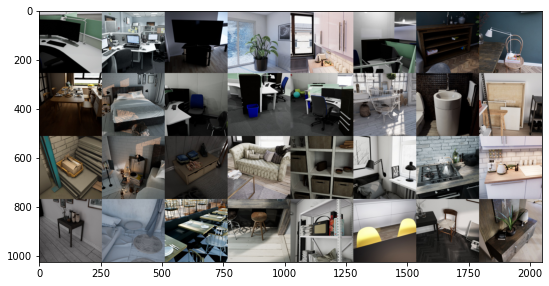

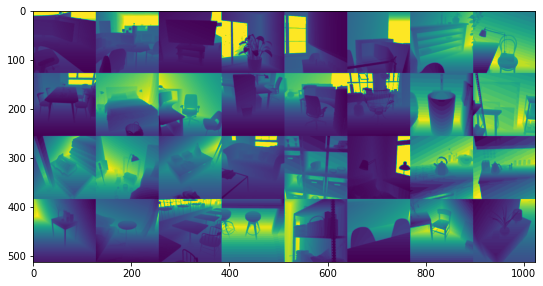

In [ ]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(sample['image'].shape, sample['depth'].shape)
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

In [ ]:
sample['image'].device

device(type='cpu')

## Model

1. We use Resnet34 as the backbone.
2. The output_stride of the ResNet model is going to be 16. This means we modify one strided convolution.
3. Both papers (DeepLab V3 & V3+) show that using pretrained weights for the backbone/encoder improves performance, so we want to use pretrained weights.
4. In order to use pretrained weights, and change the output stride, we modify the attributes of the layers of the network. 

In [ ]:
model = resnet34(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.layer4[0].downsample[0]

Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)

In [ ]:
class DepthWiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthWiseSeparableConv, self).__init__()
        
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Model(nn.Module):
    def __init__(self,
                output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
        super(Model, self).__init__()

        self.output_stride = output_stride 
        self.atrous_rate_conv = atrous_conv_rate
        self.feat_spatial_size = feat_spatial_size  # This is the height and width of extracted features
        self.dilation_rates = dilation_rates # The dilation rates for the ASPP module
        self.use_decoder = use_decoder # if False, use DeeplabV3 else DeeplabV3+
        self.backbone_feats_dim = backbone_feats_dim # This is what the 
        self.decoder_feats_dim = decoder_feats_dim # Use this consistently after the ASPP
        self.num_classes = num_classes # Use to control the number of channels in the output

        
        self.backbone = resnet34(pretrained=True)
        # Setup the correct Resnet34 network.
        # This means taking an instantiated network and replacing stride 2 on the last layer
        # with stride 1 and dilation 2.
        # https://discuss.pytorch.org/t/how-to-transfer-the-pretrained-weights-for-a-standard-resnet50-to-a-4-channel/52252
        conv_weight = self.backbone.layer4[0].conv1.weight
        ds_weight = self.backbone.layer4[0].downsample[0].weight
        self.backbone.layer4[0].conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.backbone.layer4[0].downsample[0] = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, dilation=2, bias=False)
        self.backbone.layer4[0].conv1.weight = conv_weight
        self.backbone.layer4[0].downsample[0].weight = ds_weight


        # Save the last features of the backbone
        # We have to do this as forward of our model includes a flatten statement.
        # The hook should save the output of the last layer in to a dict, whose keys are the 
        # device of the output tensor and the value is the output tensor itself.
        self.last_feats = dict()
        self.last_feat_hook_handle = self._set_last_feat_hook()
        self.backbone.layer4.register_forward_hook(self.last_feat_hook_handle)


        # Add ASPP module.
        self.aspp_module = self._get_aspp_module(self.dilation_rates)
        
        if not use_decoder:
            self.decoder = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
            self.logits_generator = nn.Conv2d(5*self.decoder_feats_dim, self.num_classes, kernel_size=1, stride=1, bias=False)
        else:
            # Extract intermediate features
            self.intermediate_feats = dict()
            
            # Setup a forward hook to retrieve intermediate features 
            # in self.intermediate_feats during the forward pass. The intermediate features should have 4x
            # downsampling. Note that there are two places to extract such features -ie at the end of two layers
            # we should have features with the same spatial size (NOT channels). Use features from deeper in the mode
            # ie features obtained after more convolutions
            self.fwd_hook_handle =  self._set_fwd_hook()
            self.backbone.layer1.register_forward_hook(self.fwd_hook_handle)

            # Setup a DeeplabV3+ style decoder with separable convs
            intermediate_decoder_feat_size = 5*self.decoder_feats_dim + 64
            self.decoder = self._get_deeplabv3_decoder(intermediate_decoder_feat_size) 
            self.logits_generator = nn.Conv2d(intermediate_decoder_feat_size, self.num_classes, kernel_size=1, stride=1, bias=False)

            self.feat_upsampler = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
            self.logits_upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)



    def _set_last_feat_hook(self):
        # https://discuss.pytorch.org/t/extract-features-from-layer-of-submodule-of-a-model/20181
        def hook(model, input, output):
            self.last_feats[output.device] = output.detach()
        return hook
        

    def _get_aspp_module(self, dilation_rates):
        # Return 3 dilated convs+activation modules depending on the dilation_rates 
        # plus a 1x1 conv and  global averaging module
        
        list_of_modules =  [nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=1, stride=1, bias=False)] 
        
        list_of_modules += [nn.Sequential(
            nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=3, stride=1, dilation=rate, padding=rate, bias=False),
            nn.BatchNorm2d(self.decoder_feats_dim),
            nn.ReLU()) for rate in dilation_rates]
                
        list_of_modules += [self._get_global_avg_module()]

        return nn.ModuleList(list_of_modules)

    def _get_global_avg_module(self):
        return nn.Sequential(
            nn.AvgPool2d(self.feat_spatial_size),
            nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(self.decoder_feats_dim),
            nn.ReLU(),
            nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        )
    
    def _set_fwd_hook(self):
        def hook(model, input, output):
            self.intermediate_feats[output.device] = output.detach()
        return hook

    def _get_deeplabv3_decoder(self, feats_dim):
        return nn.Sequential(
            DepthWiseSeparableConv(in_channels=feats_dim, out_channels=feats_dim, kernel_size=3),
            nn.BatchNorm2d(feats_dim),
            nn.ReLU(),
            DepthWiseSeparableConv(in_channels=feats_dim, out_channels=feats_dim, kernel_size=3),
            nn.BatchNorm2d(feats_dim),
            nn.ReLU()
        )

    
    def forward(self, x):
        # Extract features
        _ = self.backbone(x)
        feats = self.last_feats[x.device]

        # Perfrom multiscale feature extraction on features
        aspp_feats = []
        for m in self.aspp_module:
            aspp_feats.append(m(feats))

        feats = torch.cat(aspp_feats, dim=1)

        if not self.use_decoder:
            return self.decoder(self.logits_generator(feats))
        else:
            # the hook should save intermediate features in self.intermediate_features
            feats = self.feat_upsampler(feats)
            feats = torch.cat([feats, self.intermediate_feats[x.device]], dim=1)
            feats = self.decoder(feats)
            logits =  self.logits_generator(feats)
            return self.logits_upsampler(logits)

    
def create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
              
    model = Model(output_stride=output_stride,
                atrous_conv_rate=atrous_conv_rate,
                feat_spatial_size=feat_spatial_size,
                dilation_rates=dilation_rates,
                use_decoder=use_decoder,
                backbone_feats_dim=backbone_feats_dim,
                decoder_feats_dim=decoder_feats_dim,
                num_classes=num_classes)
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

"\nmodel = create_model_gpu(output_stride=16,\n                atrous_conv_rate=2,\n                feat_spatial_size=16,\n                dilation_rates=[3, 6, 9],\n                use_decoder=False,\n                backbone_feats_dim=512,\n                decoder_feats_dim=256,\n                num_classes=1)\nprint('Ready to train.')\n\n#model.load_state_dict(torch.load('trained_model.pkl'))\n"

## Loss Function

In [ ]:
import torch
from math import exp
import torch.nn.functional as F


def loss_fn(pred_y, y):
    l1 = nn.L1Loss()
    return l1(pred_y, y)

## Training + Evaluation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=16,
                dilation_rates=[3, 6, 9],
                use_decoder=False,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1)
print('Ready to train.')

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



run_id = 'depth_model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Implment "poly" learning policy
power = 0.9
poly = lambda epoch: (1 - epoch/epochs)**power
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=poly)

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
            'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
    
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))
    
    # Learning rate step
    scheduler.step()

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

Ready to train.


Training depth_model_gpu[0]_n25_bs32_lr0.007

Epoch: [0][0/793]	Time 24.165 (24.165)	ETA 5:19:22	Training Loss 0.5246 (0.5246)
..............................................................................
Epoch: [0][79/793]	Time 24.125 (1912.924)	ETA 4:47:05	Training Loss 0.0933 (0.5317)
..............................................................................
Epoch: [0][158/793]	Time 24.234 (3841.882)	ETA 4:16:28	Training Loss 0.0969 (0.3147)
..............................................................................
Epoch: [0][237/793]	Time 24.220 (5738.878)	ETA 3:44:26	Training Loss 0.0922 (0.2395)
..............................................................................
Epoch: [0][316/793]	Time 23.015 (7636.641)	ETA 3:02:58	Training Loss 0.0713 (0.2073)
..............................................................................
Epoch: [0][395/793]	Time 24.521 (9541.887)	ETA 2:42:39	Training Loss 0.0815 (0.1836)
....................................

## Visual Test of the Trained Model

In [ ]:
v3 = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=16,
                dilation_rates=[3, 6, 9],
                use_decoder=False,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1)
v3.load_state_dict(torch.load('depth_model_gpu[0]_n25_bs32_lr0.007.pkl'))
print('Ready to train.')

Ready to train.


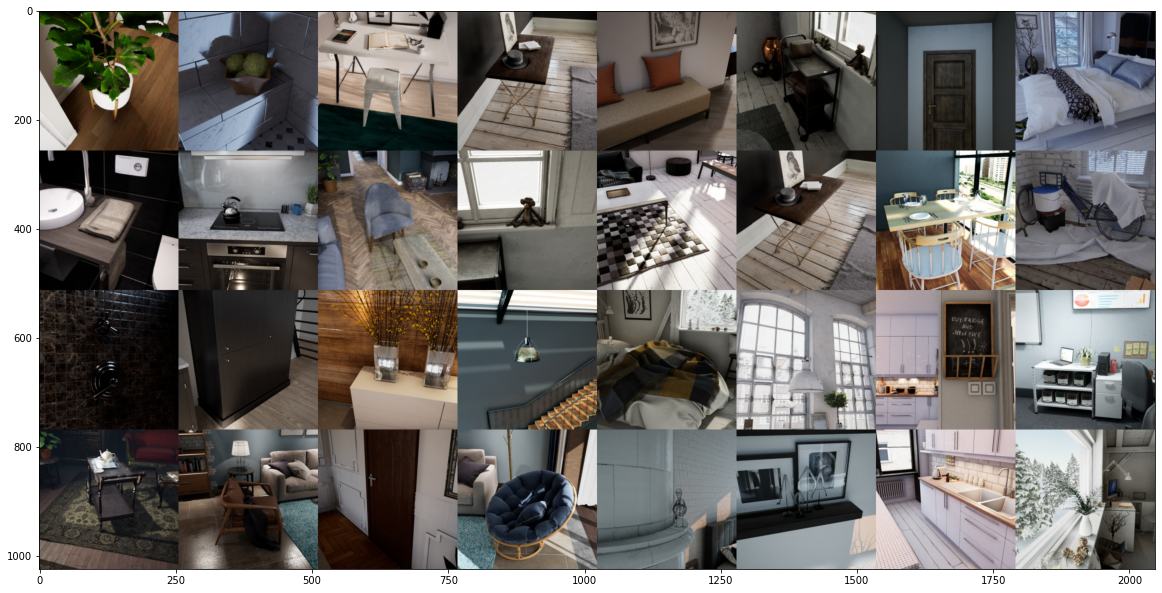

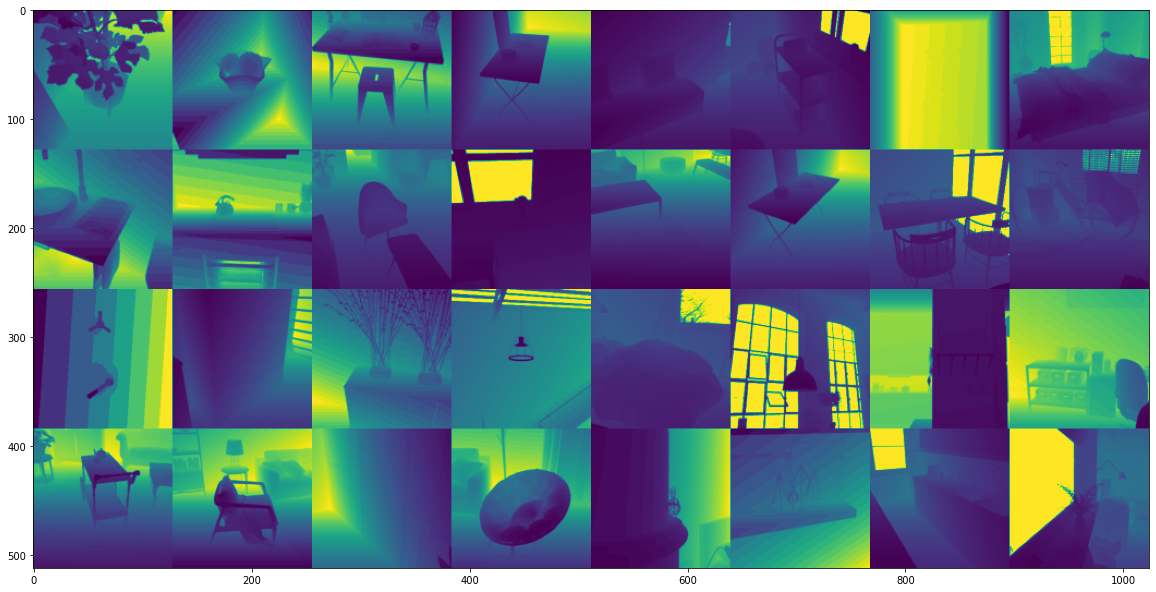

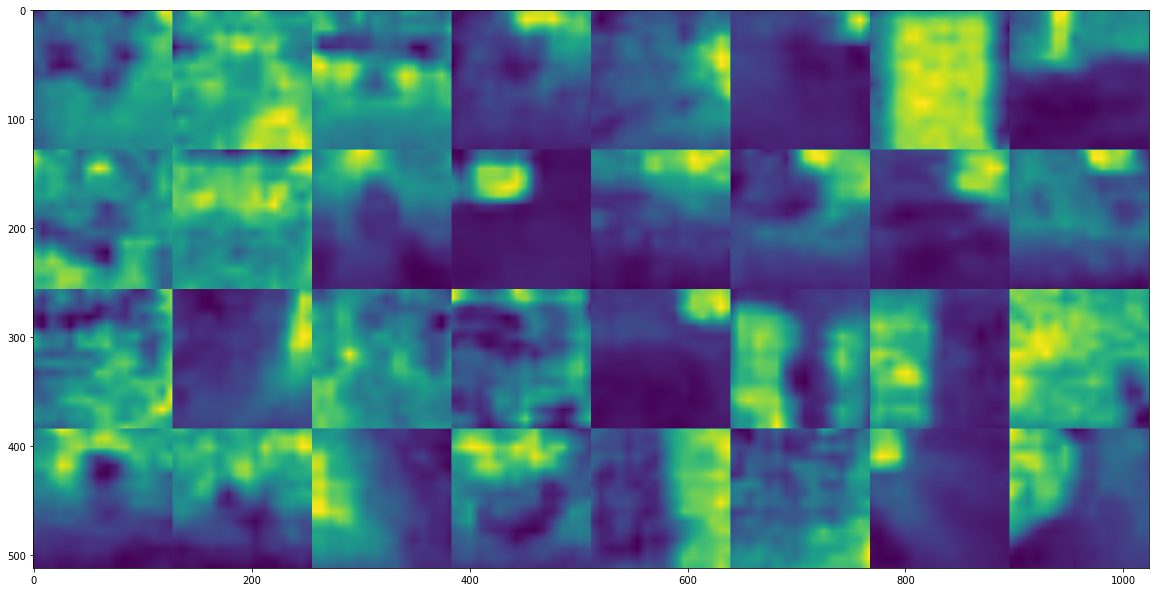

In [ ]:
v3.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['image'].float().cuda()
y_pred, y = v3(x), sample['depth']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

## DeepLabV3+ 

In [ ]:
model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=16,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1)
print('Ready to train.')

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



run_id = 'depth_model+_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Implment "poly" learning policy
power = 0.9
poly = lambda epoch: (1 - epoch/epochs)**power
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=poly)

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
            'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
    
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))
    
    # Learning rate step
    scheduler.step()

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

Ready to train.


Training depth_model+_gpu[0]_n25_bs32_lr0.007

Epoch: [0][0/793]	Time 18.344 (18.344)	ETA 4:02:27	Training Loss 0.3845 (0.3845)
..............................................................................
Epoch: [0][79/793]	Time 0.661 (734.602)	ETA 0:07:52	Training Loss 0.1027 (0.6607)
..............................................................................
Epoch: [0][158/793]	Time 17.031 (1461.988)	ETA 3:00:14	Training Loss 0.0958 (0.3812)
..............................................................................
Epoch: [0][237/793]	Time 0.664 (2192.515)	ETA 0:06:09	Training Loss 0.0886 (0.2880)
..............................................................................
Epoch: [0][316/793]	Time 16.991 (2936.338)	ETA 2:15:04	Training Loss 0.0668 (0.2351)
..............................................................................
Epoch: [0][395/793]	Time 3.085 (3662.700)	ETA 0:20:27	Training Loss 0.0726 (0.2018)
.......................................

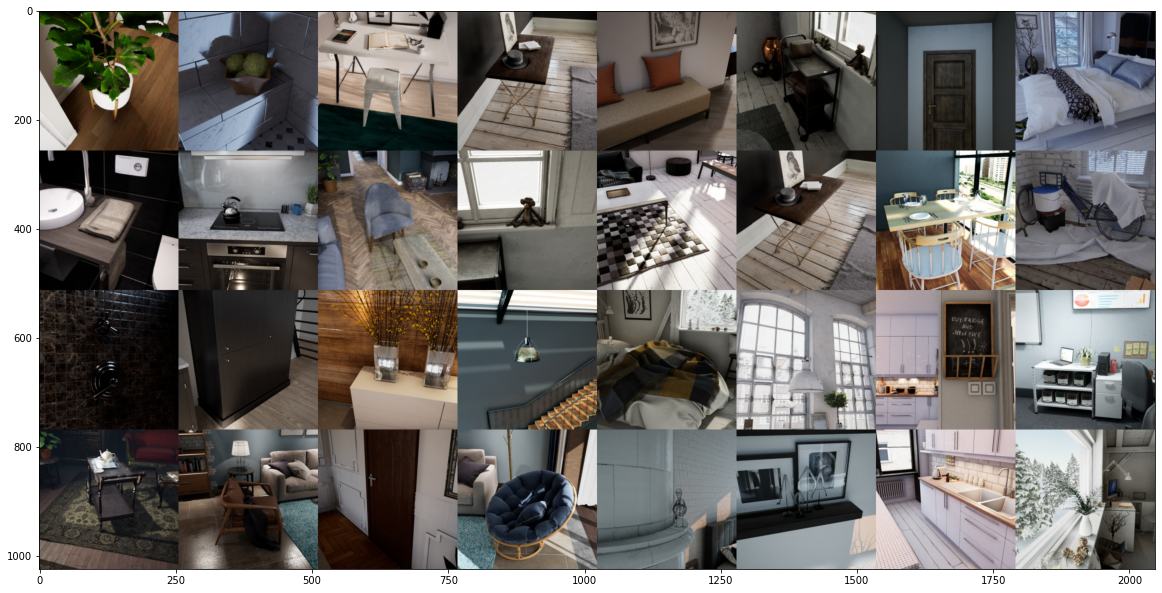

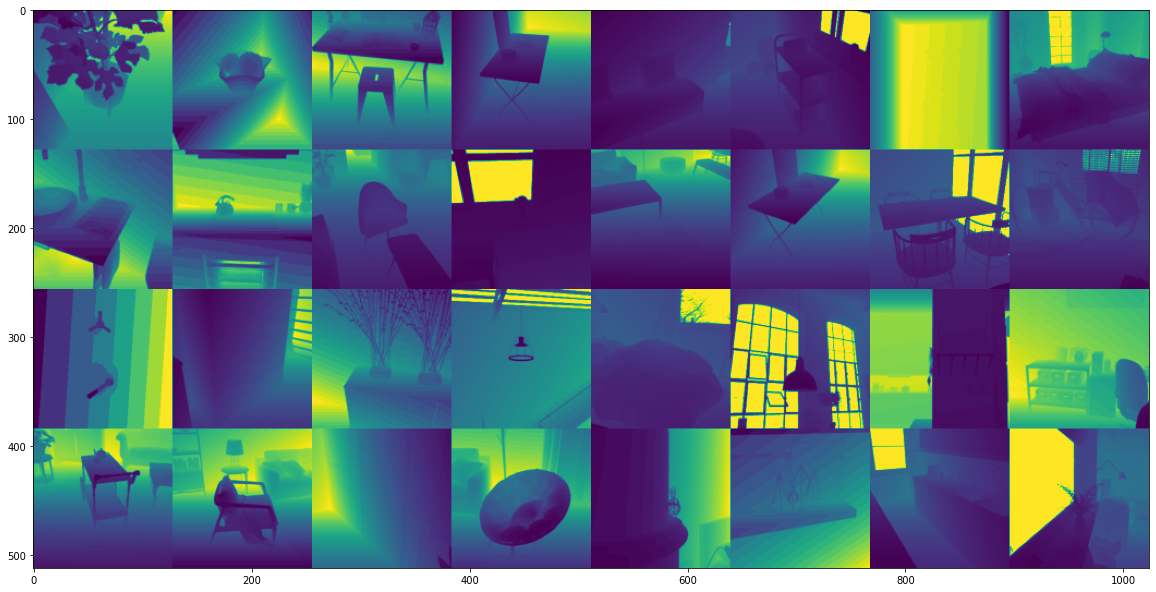

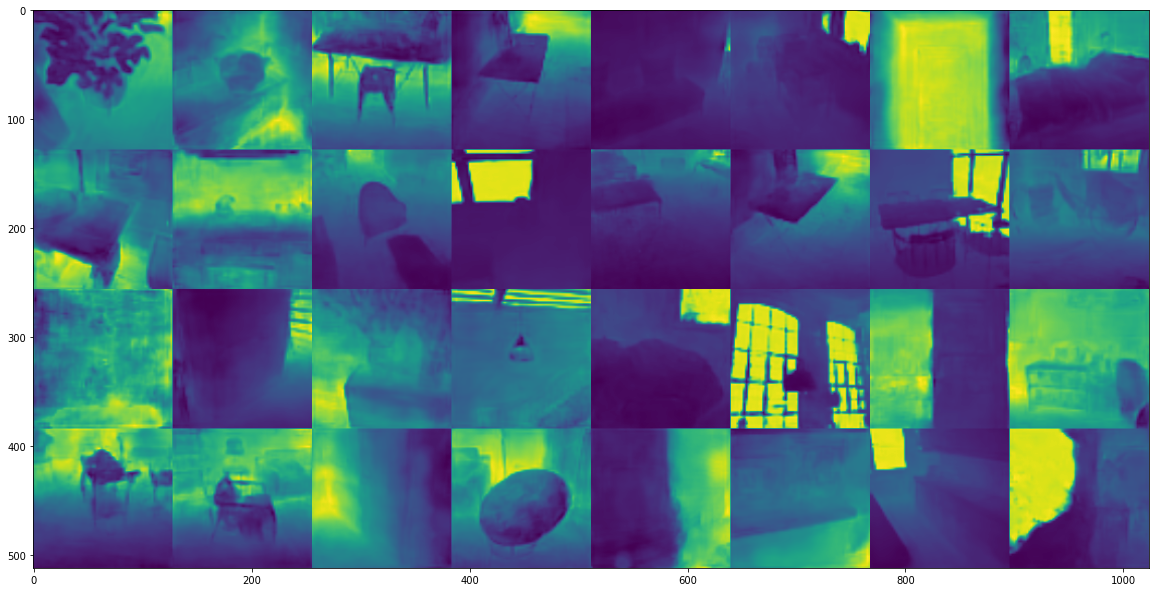

In [ ]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

# Semantic Segmentation

In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image
from skimage import io, transform
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split


class SegIdentityTransform(object):
    # This performs the scaling of the RGB by division by 255, and puts channels first by performing the permute
    # for the label, we convert to long, datatype to let torch know that this is a discrete label.
    def __call__(self, sample):
        return {'image': torch.tensor(np.array(sample['image'])/255.0).permute(2,0,1),
                'label': torch.tensor(np.array(sample['label'])).long()}

def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128],
                       [128, 128, 128],
                       [64, 0, 0],
                       [192, 0, 0],
                       [64, 128, 0],
                       [192, 128, 0],
                       [64, 0, 128],
                       [192, 0, 128],
                       [64, 128, 128],
                       [192, 128, 128],
                       [0, 64, 0],
                       [128, 64, 0],
                       [0, 192, 0],
                       [128, 192, 0],
                       [0, 64, 128]])




def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """

    if isinstance(mask, np.ndarray):
        m,n,_ = mask.shape
        cmap = get_pascal_labels().tolist()
        cArray = [[ [mask[r,c,0], mask[r,c,1], mask[r,c,2]]  for c in range(n)] for r in range(m)]
        label_map = np.asarray([[ cmap.index(cArray[r][c]) if cArray[r][c] in cmap else 255 for c in range(n)] for r in range(m)])
    else:
        label_map = np.asarray(mask)
    return label_map

def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask[mask == unk_label] = 0
    mask = mask.numpy()
    cmap = get_pascal_labels()
    cmap_exp = cmap[..., None]
    colored = cmap[mask].squeeze()
    grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2)).permute(1,2,0)
    return grid.numpy() #np.asarray(grid)



class VOCSeg(Dataset):
    def __init__(self, root_dir, split=None, transform=None):
        # Known information
        self.num_classes = 21
        self.class_names = ['Background',
                            'Aeroplane',
                            'Bicycle',
                            'Bird',
                            'Boat',
                            'Bottle',
                            'Bus',
                            'Car',
                            'Cat',
                            'Chair',
                            'Cow',
                            'Diningtable',
                            'Dog',
                            'Horse',
                            'Motorbike',
                            'Person',
                            'Pottedplant',
                            'Sheep',
                            'Sofa',
                            'Train',
                            'Tvmonitor']

        # Set up proper paths
        self.root_dir = root_dir
        self.image_dir = os.path.join(self.root_dir, 'JPEGImages')
        self.label_dir = os.path.join(self.root_dir, 'SegmentationClass')

        self.transform = transform

        #Read the appropriate split file and save the file names
        self.split = split
        self.split_file_dir = os.path.join(self.root_dir, 'ImageSets', 'Segmentation')

        # read in ONLY files from self.split_file
        self.image_files = glob.glob(self.image_dir + '/*.jpg')
        self.label_files = glob.glob(self.label_dir + '/*.png')

        with open(os.path.join(os.path.join(self.split_file_dir, self.split + '.txt')), "r") as f:
            lines = f.read().splitlines()

        self.image_files = [x for x in self.image_files if x.split("/")[3].split(".")[0] in lines]
        self.label_files = [x for x in self.label_files if x.split("/")[3].split(".")[0] in lines]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        # The images go from 0-255 to 0-1. 
        # The labels go from a 3 channel RGB to a single channel with elements in the range 0..N-1
        image = Image.open(self.image_files[idx]).resize((256,256),0)
        rgb_labels = Image.open(self.label_files[idx]).resize((256,256),0)
        labels = encode_segmap(rgb_labels) # write the encode_segmap function
        sample = {'image': image, 'label': labels}

        return self.transform(sample)


def get_seg_loaders(root_dir=None, batch_size=1, workers=1):

    tfms = transforms.Compose([
        SegIdentityTransform()
    ])

    train_set = VOCSeg(root_dir=root_dir, split='train', transform=tfms)
    val_set = VOCSeg(root_dir=root_dir, split='val', transform= SegIdentityTransform()) # No transforms on the validation set

    # Prepare data_loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)
    valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=workers)

    return train_loader, valid_loader

if __name__ == '__main__':
    pass


### Dataset
We are going to use the [PASCAL VOC dataset](https://drive.google.com/drive/folders/1G54WDNnOQecr5T0sEvZcuyme0WT5Qje3?usp=sharing), which is a commonly used benchmark.

In [ ]:
# Sanity check
if __name__ == '__main__':
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012')

    # we have read all files
    assert len(train_loader.dataset) == 1464
    assert len(valid_loader.dataset) == 1449

In [ ]:
sample = iter(train_loader).next()

In [ ]:
rgb = sample['image']
rgb.shape

torch.Size([1, 3, 256, 256])

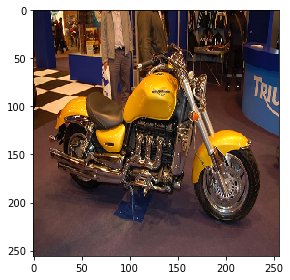

In [ ]:
io.imshow(torch.squeeze(rgb).permute(1, 2, 0).numpy())

In [ ]:
range = (torch.min(rgb), torch.max(rgb))
range

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

In [ ]:
label = sample['label']
(torch.min(label), torch.max(label))

(tensor(0), tensor(255))

In [ ]:
type(label)

torch.Tensor

In [ ]:
label.shape

torch.Size([1, 256, 256])

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


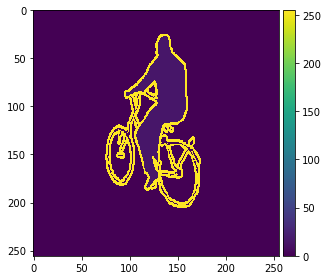

In [ ]:
io.imshow(label.numpy().squeeze())

In [ ]:
print(np.unique(label.numpy()))

[  0   2  15 255]


## Modifying the Loss and Architecture

1. The number of channels the last layer predicts must change to the number of classes in the dataset.
2. The loss function must change to reflect the fact that we are now performing per-pixel classification. 
3. CUDA assert error. This means that we have a label higher than the number of channels in the _logits_. This is very common with semantic segmentation, where you might want to label some region unkown as it's label might be under doubt - for example near the edges of objects. Ignore certain labels with a classification loss.
4. Take care of input label and logit sizes. We want predictions to be 256x256 as well.

In [ ]:
import os
import gc
import time
import datetime
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
import torch

class DepthWiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthWiseSeparableConv, self).__init__()
        
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Model(nn.Module):
    def __init__(self,
                output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
        super(Model, self).__init__()

        self.output_stride = output_stride 
        self.atrous_rate_conv = atrous_conv_rate
        self.feat_spatial_size = feat_spatial_size  # This is the height and width of extracted features
        self.dilation_rates = dilation_rates # The dilation rates for the ASPP module
        self.use_decoder = use_decoder # if False, use DeeplabV3 else DeeplabV3+
        self.backbone_feats_dim = backbone_feats_dim # This is what the 
        self.decoder_feats_dim = decoder_feats_dim # Use this consistently after the ASPP
        self.num_classes = num_classes # Use to control the number of channels in the output

        
        self.backbone = resnet34(pretrained=True)
        conv_weight = self.backbone.layer4[0].conv1.weight
        ds_weight = self.backbone.layer4[0].downsample[0].weight
        self.backbone.layer4[0].conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.backbone.layer4[0].downsample[0] = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, dilation=2, bias=False)
        self.backbone.layer4[0].conv1.weight = conv_weight
        self.backbone.layer4[0].downsample[0].weight = ds_weight


        self.last_feats = dict()
        self.last_feat_hook_handle = self._set_last_feat_hook()
        self.backbone.layer4.register_forward_hook(self.last_feat_hook_handle)


        # Add ASPP module.
        self.aspp_module = self._get_aspp_module(self.dilation_rates)
        
        if not use_decoder:
            self.decoder = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
            self.logits_generator = nn.Conv2d(5*self.decoder_feats_dim, self.num_classes, kernel_size=1, stride=1, bias=False)
        else:
            # Extract intermediate features
            self.intermediate_feats = dict()
            
            self.fwd_hook_handle =  self._set_fwd_hook()
            self.backbone.layer1.register_forward_hook(self.fwd_hook_handle)

            # Setup a DeeplabV3+ style decoder with separable convs
            intermediate_decoder_feat_size = 5*self.decoder_feats_dim + 64
            self.decoder = self._get_deeplabv3_decoder(intermediate_decoder_feat_size) 
            self.logits_generator = nn.Conv2d(intermediate_decoder_feat_size, self.num_classes, kernel_size=1, stride=1, bias=False)

            self.feat_upsampler = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
            self.logits_upsampler = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)


    def _set_last_feat_hook(self):
        # https://discuss.pytorch.org/t/extract-features-from-layer-of-submodule-of-a-model/20181
        def hook(model, input, output):
            self.last_feats[output.device] = output.detach()
        return hook
        

    def _get_aspp_module(self, dilation_rates):
        # Return 3 dilated convs+activation modules depending on the dilation_rates 
        # plus a 1x1 conv and  global averaging module
        
        list_of_modules =  [nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=1, stride=1, bias=False)] 
        
        list_of_modules += [nn.Sequential(
            nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=3, stride=1, dilation=rate, padding=rate, bias=False),
            nn.BatchNorm2d(self.decoder_feats_dim),
            nn.ReLU()) for rate in dilation_rates]
                
        list_of_modules += [self._get_global_avg_module()]

        return nn.ModuleList(list_of_modules)

    def _get_global_avg_module(self):
        return nn.Sequential(
            nn.AvgPool2d(self.feat_spatial_size),
            nn.Conv2d(self.backbone_feats_dim, self.decoder_feats_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(self.decoder_feats_dim),
            nn.ReLU(),
            nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        )
    
    def _set_fwd_hook(self):
        def hook(model, input, output):
            self.intermediate_feats[output.device] = output.detach()
        return hook

    def _get_deeplabv3_decoder(self, feats_dim):

        return nn.Sequential(
            DepthWiseSeparableConv(in_channels=feats_dim, out_channels=feats_dim, kernel_size=3),
            nn.BatchNorm2d(feats_dim),
            nn.ReLU(),
            DepthWiseSeparableConv(in_channels=feats_dim, out_channels=feats_dim, kernel_size=3),
            nn.BatchNorm2d(feats_dim),
            nn.ReLU()
        )

    
    def forward(self, x):
        # Extract features
        _ = self.backbone(x)
        feats = self.last_feats[x.device]

        # Perfrom multiscale feature extraction on features
        aspp_feats = []
        for m in self.aspp_module:
            aspp_feats.append(m(feats))

        feats = torch.cat(aspp_feats, dim=1)

        if not self.use_decoder:
            return self.decoder(self.logits_generator(feats))
        else:
            # the hook should save intermediate features in self.intermediate_features
            feats = self.feat_upsampler(feats)
            feats = torch.cat([feats, self.intermediate_feats[x.device]], dim=1)
            feats = self.decoder(feats)
            logits =  self.logits_generator(feats)
            return self.logits_upsampler(logits)

    
def create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
              
    model = Model(output_stride=output_stride,
                atrous_conv_rate=atrous_conv_rate,
                feat_spatial_size=feat_spatial_size,
                dilation_rates=dilation_rates,
                use_decoder=use_decoder,
                backbone_feats_dim=backbone_feats_dim,
                decoder_feats_dim=decoder_feats_dim,
                num_classes=num_classes)
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

In [ ]:
def loss_fn(pred_y, y):
    crossEntropy = nn.CrossEntropyLoss(ignore_index=255)
    return crossEntropy(pred_y, y)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 30
batch_size = 32
learning_rate = 0.0001
workers = 2 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [ ]:
if __name__ == '__main__':
    #from loaders import get_seg_loaders
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012', batch_size=batch_size, workers=workers)

## Training and Evaluation



In [ ]:
model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=16,
                dilation_rates=[3, 6, 9],
                use_decoder=False,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=21)
print('Ready to train.')

Ready to train.


In [ ]:
from utils import Metrics

run_id = 'seg_model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Implment "poly" learning policy
#power = 0.9
#poly = lambda epoch: (1 - epoch/epochs)**power
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=poly)

metrics = Metrics(train_loader.dataset.num_classes, train_loader.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['label'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)


        # Compute and print loss.
        loss = loss_fn(y_pred, y.long())

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())

    # Take learning rate step
    #scheduler.step()


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training seg_model_gpu[0]_n30_bs32_lr0.0001


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: [0][0/46]	Time 0.711 (0.711)	ETA 0:00:32	Training Loss 2.9028 (2.9028)

Epoch: [0][4/46]	Time 0.282 (1.448)	ETA 0:00:11	Training Loss 2.2120 (2.5440)

Epoch: [0][8/46]	Time 0.296 (2.264)	ETA 0:00:11	Training Loss 1.7168 (2.2665)

Epoch: [0][12/46]	Time 0.324 (3.139)	ETA 0:00:11	Training Loss 1.2143 (2.0025)

Epoch: [0][16/46]	Time 0.270 (3.944)	ETA 0:00:08	Training Loss 1.4000 (1.8794)

Epoch: [0][20/46]	Time 0.269 (4.772)	ETA 0:00:07	Training Loss 1.4065 (1.7887)

Epoch: [0][24/46]	Time 0.256 (5.573)	ETA 0:00:05	Training Loss 1.4829 (1.7184)

Epoch: [0][28/46]	Time 0.279 (6.387)	ETA 0:00:05	Training Loss 1.4762 (1.6871)

Epoch: [0][32/46]	Time 0.285 (7.215)	ETA 0:00:03	Training Loss 1.1246 (1.6304)

Epoch: [0][36/46]	Time 0.247 (8.028)	ETA 0:00:02	Training Loss 1.2674 (1.5906)

Epoch: [0][40/46]	Time 0.295 (8.861)	ETA 0:00:01	Training Loss 0.9999 (1.5474)

Epoch: [0][44/46]	Time 0.280 (9.695)	ETA 0:00:00	Training Loss 1.0982 (1.5172)
___________________________________________

In [ ]:
model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=16,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=21)
print('Ready to train.')

Ready to train.


In [ ]:
from utils import Metrics

run_id = 'seg_model+_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Implment "poly" learning policy
#power = 0.9
#poly = lambda epoch: (1 - epoch/epochs)**power
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=poly)

metrics = Metrics(train_loader.dataset.num_classes, train_loader.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['label'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)


        # Compute and print loss.
        loss = loss_fn(y_pred, y.long())

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())

    # Take learning rate step
    #scheduler.step()


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training seg_model+_gpu[0]_n30_bs32_lr0.0001

Epoch: [0][0/46]	Time 0.817 (0.817)	ETA 0:00:37	Training Loss 2.8208 (2.8208)

Epoch: [0][4/46]	Time 0.681 (3.530)	ETA 0:00:28	Training Loss 2.4668 (2.6371)

Epoch: [0][8/46]	Time 0.680 (6.250)	ETA 0:00:25	Training Loss 2.2668 (2.4938)

Epoch: [0][12/46]	Time 0.680 (8.972)	ETA 0:00:23	Training Loss 1.9837 (2.3677)

Epoch: [0][16/46]	Time 0.678 (11.695)	ETA 0:00:20	Training Loss 1.7952 (2.2507)

Epoch: [0][20/46]	Time 0.682 (14.412)	ETA 0:00:17	Training Loss 1.8231 (2.1577)

Epoch: [0][24/46]	Time 0.681 (17.135)	ETA 0:00:14	Training Loss 1.4243 (2.0724)

Epoch: [0][28/46]	Time 0.679 (19.847)	ETA 0:00:12	Training Loss 1.5805 (1.9946)

Epoch: [0][32/46]	Time 0.679 (22.560)	ETA 0:00:09	Training Loss 1.4044 (1.9227)

Epoch: [0][36/46]	Time 0.681 (25.278)	ETA 0:00:06	Training Loss 1.2540 (1.8631)

Epoch: [0][40/46]	Time 0.678 (27.988)	ETA 0:00:04	Training Loss 1.1835 (1.8111)

Epoch: [0][44/46]	Time 0.677 (30.703)	ETA 0:00:01	Training Loss 1.41